# 프로젝트: 네이버 영화리뷰 감성분석하기
사용한 데이터셋:https://github.com/e9t/nsmc

## Data Description
#### columns
* id: review id
* document: 실제 리뷰
* label: 리뷰의 감성 (0: 부정적, 1: 긍정적)

#### 데이터 구성
총 200,000개 리뷰로 구성
* ratings.txt: All 200K reviews
* ratings_test.txt: 50K reviews held out for testing
* ratings_train.txt: 150K reviews for training

## Data and Module load

In [578]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
from konlpy.tag import Mecab
import math
import os


# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### Data loader

In [579]:
# 단어 인덱스 리스트 벡터로 변환
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

stopwords는 RANKS NL에서 제공하는 Korean Stopwords를 활용했다.
https://www.ranks.nl/stopwords/korean

In [580]:
from konlpy.tag import Mecab
import re
tokenizer = Mecab()
#stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
stopwords = pd.read_csv('~/aiffel/sentiment_classification/data/Korean_Stopwords.txt').values.tolist()
stopwords = [word for x in stopwords for word in x]

def sentence_preprocessing(sentence_df):    
    sentence_df = sentence_df.str.replace("([^\u3131-\u314e|\u314f-\u3163|\uac00-\ud7a3])","", regex = True)
    sentence_df = sentence_df.str.replace("^ +","", regex = True)
    sentence_df = sentence_df.str.replace("([\u3131-\u314e\u314f-\u3163]+)","", regex = True)
    sentence_df.replace('', np.nan, inplace=True)
    return sentence_df
    
def load_data(train_data, test_data, num_words=10000):    
    # 데이터의 중복 제거
    train_data.drop_duplicates(['document'], keep='first', inplace=True)
    test_data.drop_duplicates(['document'], keep='first', inplace=True)
    # 정규 표현식으로 데이터 전처리
    train_data['document'] = sentence_preprocessing(train_data['document'])
    test_data['document'] = sentence_preprocessing(test_data['document'])
    # NaN 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')
    # 한국어 토크나이저로 토큰화
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        # 불용어(Stopwords) 제거
        temp_X = [word for word in temp_X if not word in stopwords]
        X_train.append(temp_X)    
        
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        # 불용어(Stopwords) 제거
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)    
    
    # 사전word_to_index 구성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    vocab = ['<PAD>','<BOS>','<UNK>','<UNUSED>']+[key for key,_ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 텍스트 스트링을 사전 인덱스 스트링으로 변환
    
    def wordlist_to_indexlist(wordlist):        
        indexlist = get_encoded_sentence(wordlist, word_to_index)    
        return indexlist
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    y_train = np.array(list(train_data['label']))
    y_test = np.array(list(test_data['label']))
    # X_train, y_train, X_test, y_test, word_to_index 리턴
    return X_train, y_train, X_test, y_test, word_to_index

### 데이터 전처리

In [581]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
index_to_word = {index:word for word, index in word_to_index.items()}

In [582]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '는': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '도': 8,
 '은': 9,
 '한': 10,
 '보': 11,
 '게': 12,
 '지': 13,
 '있': 14,
 '없': 15,
 '좋': 16,
 '었': 17,
 '는데': 18,
 '만': 19,
 '너무': 20,
 '봤': 21,
 '적': 22,
 '안': 23,
 '정말': 24,
 '음': 25,
 '네요': 26,
 '같': 27,
 '재밌': 28,
 '진짜': 29,
 '했': 30,
 '기': 31,
 '않': 32,
 '았': 33,
 '거': 34,
 '수': 35,
 '되': 36,
 '면': 37,
 '인': 38,
 '말': 39,
 '연기': 40,
 '점': 41,
 '잘': 42,
 '최고': 43,
 '평점': 44,
 '주': 45,
 '내': 46,
 '던': 47,
 '할': 48,
 '어요': 49,
 '겠': 50,
 '스토리': 51,
 '해': 52,
 '듯': 53,
 '드라마': 54,
 '생각': 55,
 '싶': 56,
 '사람': 57,
 '더': 58,
 '감동': 59,
 '배우': 60,
 '함': 61,
 '본': 62,
 '보다': 63,
 '만들': 64,
 '뭐': 65,
 '내용': 66,
 '알': 67,
 '감독': 68,
 '볼': 69,
 '라': 70,
 '그냥': 71,
 '재미있': 72,
 '지루': 73,
 '중': 74,
 '재미없': 75,
 '재미': 76,
 '였': 77,
 '잼': 78,
 '사랑': 79,
 '쓰레기': 80,
 '못': 81,
 '냐': 82,
 '라고': 83,
 '서': 84,
 '다시': 85,
 '니': 86,
 '면서': 87,
 '나오': 88,
 '작품': 89,
 '번': 90,
 '이거': 91,
 '해서': 92,
 '줄': 93,
 '끝': 94,
 

### 데이터 분석 및 가공

* 데이터셋 내 문장 길이 분포
* 적절한 최대 문장 길이 지정
* keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

#### 데이터셋 내 문장 길이 분포 확인
시각화를 통해 문장 길이의 분포를 확인하였다.

In [583]:
len_dataset= np.array(list(map(len,X_train)))
len_dataset= pd.Series(len_dataset)
print(f'문장의 최소길이: {len_dataset.min()}')
print(f'문장의 최대길이: {len_dataset.max()}')
print(f'문장의 평균길이: {len_dataset.mean()}')
print(f'문장의 길이 표준편차: {len_dataset.std()}')

문장의 최소길이: 1
문장의 최대길이: 79
문장의 평균길이: 13.695279797312184
문장의 길이 표준편차: 10.736632134968463


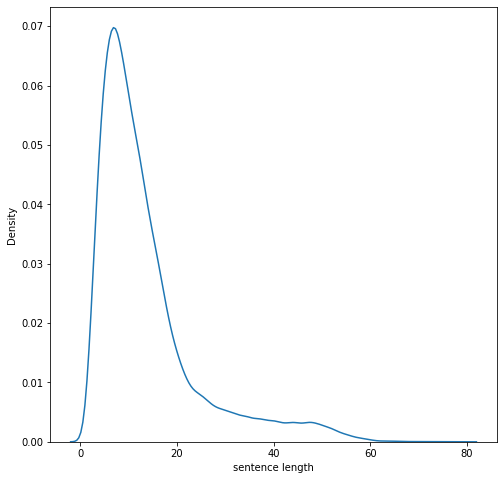

In [584]:
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize=(8,8))
sns.kdeplot(len_dataset, ax=ax)
ax.set_xlabel('sentence length')
plt.show()

In [585]:
max_sentence_length = round(len_dataset.mean()+(len_dataset.std()*2))

In [586]:
percent = round(np.sum(len_dataset<max_sentence_length)/len(len_dataset)*100)
print(f'최대 길이가 {max_sentence_length}일때 {percent}% 포함된다.')

최대 길이가 35일때 93% 포함된다.


적절한 길이만큼 자르고 padding을 추가하는 함수를 만든다.    
(padding 방식에 따른 성능 비교를 위해)

In [587]:
def preprocessing_padding(dataset,word_to_index, max_sentence_length=42, padding_type='pre'):
    """
    params:
        padding_type: pre, post
    """
    raw_inputs = keras.preprocessing.sequence.pad_sequences(dataset, 
                                                            value=word_to_index['<PAD>'],
                                                            padding=padding_type,
                                                            maxlen=max_sentence_length)
    return raw_inputs

In [588]:
X_train = preprocessing_padding(X_train, word_to_index)
X_test = preprocessing_padding(X_test, word_to_index)

### 모델 구성 및 validation set 구성

#### RNN을 이용한 레이어 구성

In [589]:
def rnn_layer(vocab_size=10000, word_vector_dim=4):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.LSTM(8))
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

In [590]:
model = rnn_layer()
model.summary()

Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_121 (Embedding)    (None, None, 4)           40000     
_________________________________________________________________
lstm_100 (LSTM)              (None, 8)                 416       
_________________________________________________________________
dense_232 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_233 (Dense)            (None, 1)                 9         
Total params: 40,497
Trainable params: 40,497
Non-trainable params: 0
_________________________________________________________________


#### CNN을 이용한 레이어 구성

In [591]:
def cnn_layer(vocab_size=10000, word_vector_dim=4):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.MaxPooling1D(5))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

In [592]:
model = cnn_layer()
model.summary()

Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_122 (Embedding)    (None, None, 4)           40000     
_________________________________________________________________
conv1d_62 (Conv1D)           (None, None, 16)          464       
_________________________________________________________________
max_pooling1d_31 (MaxPooling (None, None, 16)          0         
_________________________________________________________________
conv1d_63 (Conv1D)           (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_45 (Glo (None, 16)                0         
_________________________________________________________________
dense_234 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_235 (Dense)            (None, 1)              

### Global MaxPooling을 이용한 레이어 구성

In [593]:
def gmp_layer(vocab_size=10000, word_vector_dim=4):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid')) 
    return model

In [594]:
model = gmp_layer()
model.summary()

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_123 (Embedding)    (None, None, 4)           40000     
_________________________________________________________________
global_max_pooling1d_46 (Glo (None, 4)                 0         
_________________________________________________________________
dense_236 (Dense)            (None, 8)                 40        
_________________________________________________________________
dense_237 (Dense)            (None, 1)                 9         
Total params: 40,049
Trainable params: 40,049
Non-trainable params: 0
_________________________________________________________________


#### Validation set 구성

In [595]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train,  y_val = train_test_split(X_train, y_train, random_state=2021, test_size = 0.2)

In [596]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((116198, 42), (116198,), (29050, 42), (29050,))

### 모델 훈련

accuracy와 loss 시각화를 위해 따로 분리했다.

In [597]:
def display_acc_loss(history_dict):
    acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    
    epochs = range(1,len(acc)+1)
    
    fig, ax = plt.subplots(2,1, figsize=(15,10))
    ax[0].plot(epochs, loss,'r',label='Training loss')
    ax[0].plot(epochs, val_loss,'b',label='Validation loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].plot(epochs, acc,'r',label='Training acc')
    ax[1].plot(epochs, val_acc,'b',label='Validation acc')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    
    plt.show()

##### rnn

In [598]:
model = rnn_layer()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs=20
history=model.fit(X_train, 
                  y_train, 
                  epochs=epochs, 
                  batch_size=512, 
                  validation_data=(X_val, y_val), 
                  verbose=1)

Epoch 1/20
227/227 [==============================] - 4s 11ms/step - loss: 0.6509 - accuracy: 0.6226 - val_loss: 0.4133 - val_accuracy: 0.8204
Epoch 2/20
227/227 [==============================] - 2s 9ms/step - loss: 0.3801 - accuracy: 0.8356 - val_loss: 0.3765 - val_accuracy: 0.8314
Epoch 3/20
227/227 [==============================] - 2s 9ms/step - loss: 0.3416 - accuracy: 0.8532 - val_loss: 0.3682 - val_accuracy: 0.8381
Epoch 4/20
227/227 [==============================] - 2s 9ms/step - loss: 0.3254 - accuracy: 0.8600 - val_loss: 0.3680 - val_accuracy: 0.8383
Epoch 5/20
227/227 [==============================] - 2s 9ms/step - loss: 0.3188 - accuracy: 0.8645 - val_loss: 0.3700 - val_accuracy: 0.8351
Epoch 6/20
227/227 [==============================] - 2s 9ms/step - loss: 0.3161 - accuracy: 0.8658 - val_loss: 0.3710 - val_accuracy: 0.8359
Epoch 7/20
227/227 [==============================] - 2s 9ms/step - loss: 0.3110 - accuracy: 0.8674 - val_loss: 0.3751 - val_accuracy: 0.8357
Epoch

#### Loss, Accuracy 그래프 시각화

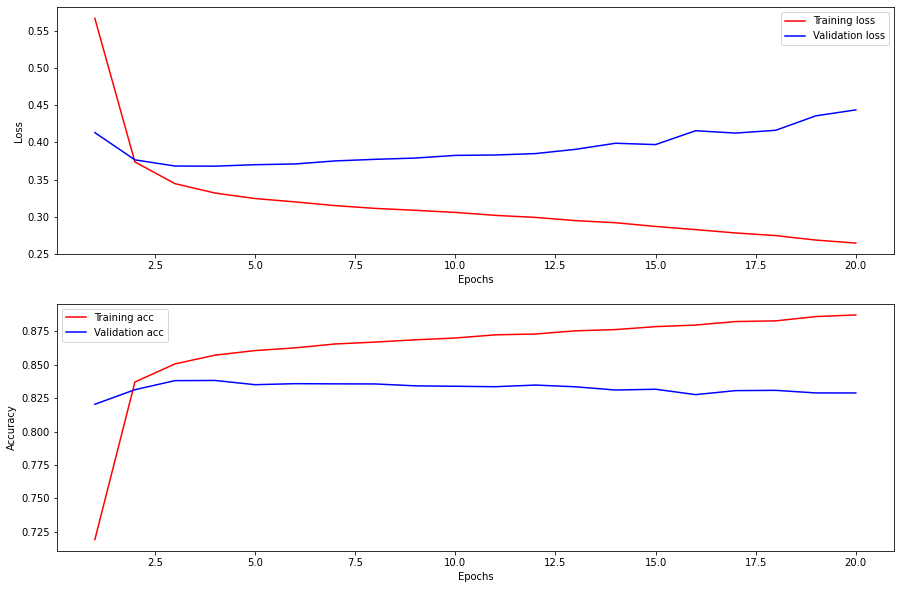

In [599]:
display_acc_loss(history.history)

#### 모델 평가

In [600]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1525/1525 - 5s - loss: 0.4427 - accuracy: 0.8282
[0.4426873028278351, 0.828163743019104]


##### cnn

In [601]:
model = cnn_layer()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs=20
history=model.fit(X_train, 
                  y_train, 
                  epochs=epochs, 
                  batch_size=512, 
                  validation_data=(X_val, y_val), 
                  verbose=1)

Epoch 1/20
227/227 [==============================] - 2s 7ms/step - loss: 0.6403 - accuracy: 0.6120 - val_loss: 0.4176 - val_accuracy: 0.8066
Epoch 2/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3893 - accuracy: 0.8248 - val_loss: 0.4036 - val_accuracy: 0.8151
Epoch 3/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3541 - accuracy: 0.8428 - val_loss: 0.3958 - val_accuracy: 0.8192
Epoch 4/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3377 - accuracy: 0.8508 - val_loss: 0.3983 - val_accuracy: 0.8200
Epoch 5/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3241 - accuracy: 0.8585 - val_loss: 0.3995 - val_accuracy: 0.8190
Epoch 6/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3148 - accuracy: 0.8626 - val_loss: 0.4062 - val_accuracy: 0.8184
Epoch 7/20
227/227 [==============================] - 1s 6ms/step - loss: 0.3035 - accuracy: 0.8685 - val_loss: 0.4116 - val_accuracy: 0.8170
Epoch 

#### Loss, Accuracy 그래프 시각화

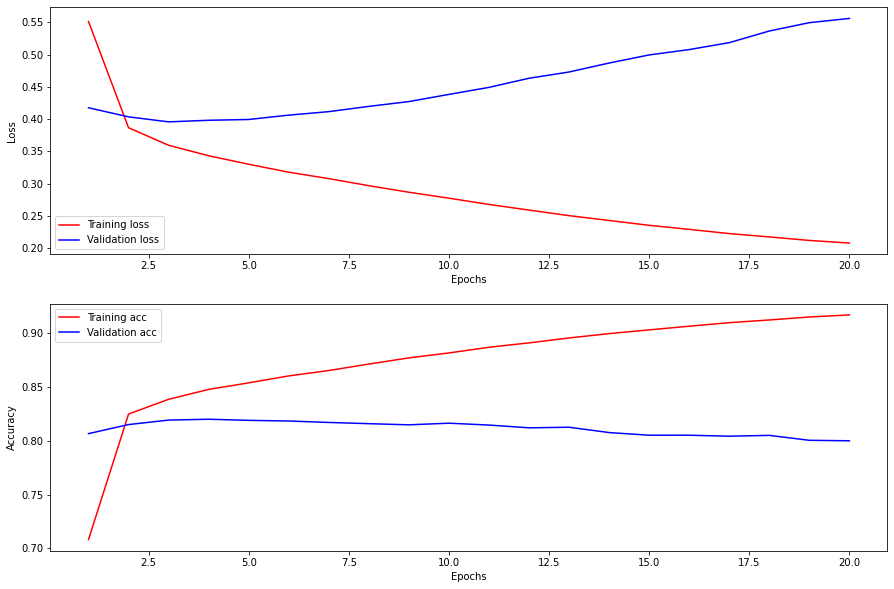

In [602]:
display_acc_loss(history.history)

#### 모델 평가

In [603]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1525/1525 - 2s - loss: 0.5630 - accuracy: 0.7959
[0.5629891157150269, 0.7958547472953796]


##### Global MaxPooling

In [604]:
model = gmp_layer()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs=20
history=model.fit(X_train, 
                  y_train, 
                  epochs=epochs, 
                  batch_size=512, 
                  validation_data=(X_val, y_val), 
                  verbose=1)

Epoch 1/20
227/227 [==============================] - 1s 4ms/step - loss: 0.6791 - accuracy: 0.5926 - val_loss: 0.5656 - val_accuracy: 0.7730
Epoch 2/20
227/227 [==============================] - 1s 3ms/step - loss: 0.5137 - accuracy: 0.7914 - val_loss: 0.4327 - val_accuracy: 0.8083
Epoch 3/20
227/227 [==============================] - 1s 3ms/step - loss: 0.4037 - accuracy: 0.8284 - val_loss: 0.4055 - val_accuracy: 0.8176
Epoch 4/20
227/227 [==============================] - 1s 3ms/step - loss: 0.3690 - accuracy: 0.8412 - val_loss: 0.3984 - val_accuracy: 0.8219
Epoch 5/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3462 - accuracy: 0.8519 - val_loss: 0.3972 - val_accuracy: 0.8238
Epoch 6/20
227/227 [==============================] - 1s 4ms/step - loss: 0.3352 - accuracy: 0.8556 - val_loss: 0.3984 - val_accuracy: 0.8246
Epoch 7/20
227/227 [==============================] - 1s 3ms/step - loss: 0.3225 - accuracy: 0.8637 - val_loss: 0.4018 - val_accuracy: 0.8241
Epoch 

#### Loss, Accuracy 그래프 시각화

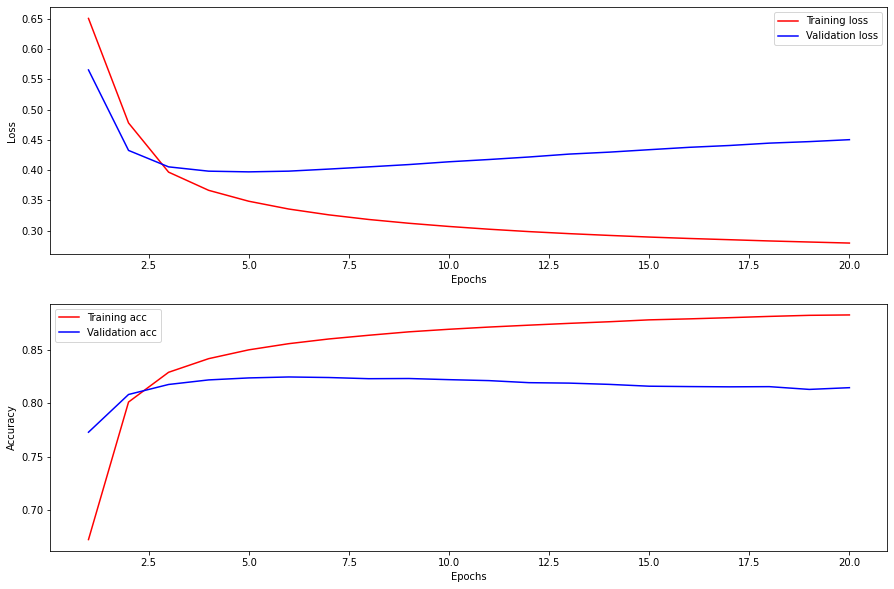

In [605]:
display_acc_loss(history.history)

#### 모델 평가

In [606]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1525/1525 - 2s - loss: 0.4450 - accuracy: 0.8171
[0.4450445771217346, 0.81705242395401]


### 학습된 embedding 레이어 분석

In [607]:
embedding_layer=model.layers[0]
weights=embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 4)


워드 벡터를 저장

In [608]:
vocab_size = weights.shape[0]
word_vector_dim = weights.shape[1]
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [609]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['연출']
vector

array([-0.21985333,  0.03440103, -0.3349444 , -0.23761065], dtype=float32)

In [610]:
keys = []
for key, distance in word_vectors.similar_by_word('연출'):
    print(key)
    keys.append(word_to_index[key])

드라
나왔
발언
제목
놀래키
거꾸로
가해자
중간
재산
시초


#### embedding 레이어 시각화

In [611]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
y = tsne.fit_transform(weights)
y.shape

(10000, 2)

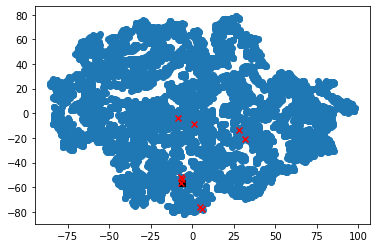

In [612]:
plt.scatter(y[:,0], y[:,1])
for idx, key in enumerate(keys):            
    if idx == 0:
        plt.scatter(y[key,0], y[key,1], marker='s', c='black')
        continue
    plt.scatter(y[key,0], y[key,1], marker='x', c='r')

유사한 단어를 잘 찾지 못해 한국어 임베딩을 활용해 성능을 개선해보려고 한다.

### 한국어 Word2Vec 임베딩을 활용해 성능 개선

https://github.com/Kyubyong/wordvectors

In [613]:
!pip install --upgrade gensim==3.8.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [614]:
import gensim

korean_word2Vec_Path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
korean_word_vectors_model = gensim.models.Word2Vec.load(korean_word2Vec_Path)

In [615]:
korean_word_vectors_model.wv.most_similar('연출')

[('각색', 0.6428115367889404),
 ('각본', 0.6311596632003784),
 ('재현', 0.6283892393112183),
 ('연극', 0.5993435382843018),
 ('뮤지컬', 0.598302960395813),
 ('안무', 0.5873018503189087),
 ('배역', 0.5813403129577637),
 ('극본', 0.5810103416442871),
 ('작화', 0.5745235085487366),
 ('코미디', 0.5699306726455688)]

In [616]:
vocab_size = weights.shape[0]
word_vector_dim = korean_word_vectors_model.wv['연출'].shape[0]

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4, vocab_size):
    if index_to_word[i] in korean_word_vectors_model.wv:
        embedding_matrix[i] = korean_word_vectors_model.wv[index_to_word[i]]

In [617]:
vocab_size = embedding_matrix.shape[0]
word_vector_dim = embedding_matrix.shape[1]
word2vec_kr_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_kr.txt'
f = open(word2vec_kr_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(embedding_matrix[i, :])))))
f.close()

In [618]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_kr_file_path, binary=False)

#### embedding 레이어 시각화

In [619]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
y = tsne.fit_transform(embedding_matrix)
y.shape

(10000, 2)

각색 각본 재현 연극 뮤지컬 배역 극본 작화 코미디 감상 

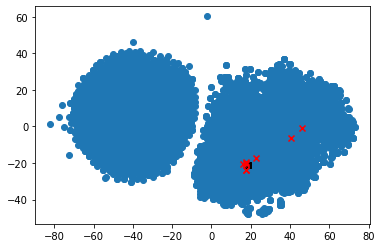

In [620]:
keys = []
for key, distance in word_vectors.similar_by_word('연출'):
    print(key, end=' ')
    keys.append(word_to_index[key])
    
plt.scatter(y[:,0], y[:,1])
for idx, key in enumerate(keys):            
    if idx == 0:
        plt.scatter(y[key,0], y[key,1], marker='s', c='black')
        continue
    plt.scatter(y[key,0], y[key,1], marker='x', c='r')

그다지 전혀 따로 마다 별 딱히 엄연히 별반 대체로 아예 

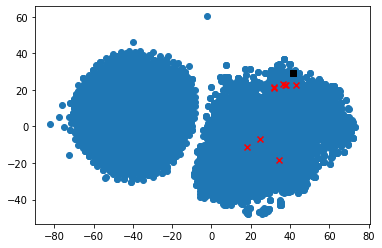

In [621]:
keys = []
for key, distance in word_vectors.similar_by_word('별로'):
    print(key, end=' ')
    keys.append(word_to_index[key])
    
plt.scatter(y[:,0], y[:,1])
for idx, key in enumerate(keys):            
    if idx == 0:
        plt.scatter(y[key,0], y[key,1], marker='s', c='black')
        continue
    plt.scatter(y[key,0], y[key,1], marker='x', c='r')

신기하게 두개의 그룹으로 나눠져 있는 것을 볼 수 있다. 혹시 긍정/부정 단어로 구분된 것일까?    
어떤 기준으로 나눠진건지 궁금해진다. 그래도 단어의 유사도를 살펴본 결과 제대로 학습이 된 것을 볼 수 있다.

### 바꾼 한국어 Word2Vec를 이용한 모델 훈련 및 평가

#### RNN을 이용한 레이어 구성

In [622]:
from tensorflow.keras.initializers import Constant

In [623]:
len_dataset= np.array(list(map(len,X_train)))
len_dataset= pd.Series(len_dataset)
max_sentence_length = round(len_dataset.mean()+(len_dataset.std()*2))

In [644]:
def rnn_layer(max_sentence_length, word2vec):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(word2vec.shape[0], 
                                     word2vec.shape[1], 
                                     embeddings_initializer=Constant(word2vec),
                                     input_length=max_sentence_length, ))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(max_sentence_length//4, return_sequences=True)))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(8)))
    model.add(keras.layers.Dense(8, kernel_regularizer=keras.regularizers.l2(0.002), activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

In [645]:
model = rnn_layer(max_sentence_length, embedding_matrix)
model.summary()

Model: "sequential_139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_135 (Embedding)    (None, 42, 200)           2000000   
_________________________________________________________________
bidirectional_81 (Bidirectio (None, 42, 20)            16880     
_________________________________________________________________
bidirectional_82 (Bidirectio (None, 16)                1856      
_________________________________________________________________
dense_260 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_261 (Dense)            (None, 1)                 9         
Total params: 2,018,881
Trainable params: 2,018,881
Non-trainable params: 0
_________________________________________________________________


#### CNN을 이용한 레이어 구성

In [626]:
def cnn_layer(max_sentence_length, word2vec):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(word2vec.shape[0], 
                                     word2vec.shape[1], 
                                     embeddings_initializer=Constant(word2vec),
                                     input_length=max_sentence_length, ))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.MaxPooling1D(5))
    model.add(keras.layers.Conv1D(16, 7, activation='relu'))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

In [627]:
model = cnn_layer(max_sentence_length, embedding_matrix)
model.summary()

Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_128 (Embedding)    (None, 42, 200)           2000000   
_________________________________________________________________
conv1d_66 (Conv1D)           (None, 36, 16)            22416     
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 7, 16)             0         
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_49 (Glo (None, 16)                0         
_________________________________________________________________
dense_246 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_247 (Dense)            (None, 1)              

#### Global MaxPooling을 이용한 레이어 구성

In [628]:
def gmp_layer(max_sentence_length, word2vec):
    model = keras.Sequential()
    model.add(keras.layers.Embedding(word2vec.shape[0], 
                                     word2vec.shape[1], 
                                     embeddings_initializer=Constant(word2vec),
                                     input_length=max_sentence_length, ))
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dense(8, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid')) 
    return model

In [629]:
model = gmp_layer(max_sentence_length, embedding_matrix)
model.summary()

Model: "sequential_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_129 (Embedding)    (None, 42, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_50 (Glo (None, 200)               0         
_________________________________________________________________
dense_248 (Dense)            (None, 8)                 1608      
_________________________________________________________________
dense_249 (Dense)            (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


##### cnn

In [630]:
model = cnn_layer(max_sentence_length, embedding_matrix)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs=10
history=model.fit(X_train, 
                  y_train, 
                  epochs=epochs, 
                  batch_size=512, 
                  validation_data=(X_val, y_val), 
                  verbose=1)

Epoch 1/10
227/227 [==============================] - 7s 29ms/step - loss: 0.6286 - accuracy: 0.6311 - val_loss: 0.4742 - val_accuracy: 0.7743
Epoch 2/10
227/227 [==============================] - 6s 26ms/step - loss: 0.4356 - accuracy: 0.7972 - val_loss: 0.4212 - val_accuracy: 0.8044
Epoch 3/10
227/227 [==============================] - 6s 25ms/step - loss: 0.3702 - accuracy: 0.8328 - val_loss: 0.4060 - val_accuracy: 0.8123
Epoch 4/10
227/227 [==============================] - 6s 25ms/step - loss: 0.3343 - accuracy: 0.8526 - val_loss: 0.4051 - val_accuracy: 0.8143
Epoch 5/10
227/227 [==============================] - 6s 25ms/step - loss: 0.3016 - accuracy: 0.8690 - val_loss: 0.4109 - val_accuracy: 0.8131
Epoch 6/10
227/227 [==============================] - 6s 25ms/step - loss: 0.2820 - accuracy: 0.8786 - val_loss: 0.4301 - val_accuracy: 0.8097
Epoch 7/10
227/227 [==============================] - 6s 25ms/step - loss: 0.2570 - accuracy: 0.8913 - val_loss: 0.4518 - val_accuracy: 0.8082

#### Loss, Accuracy 그래프 시각화

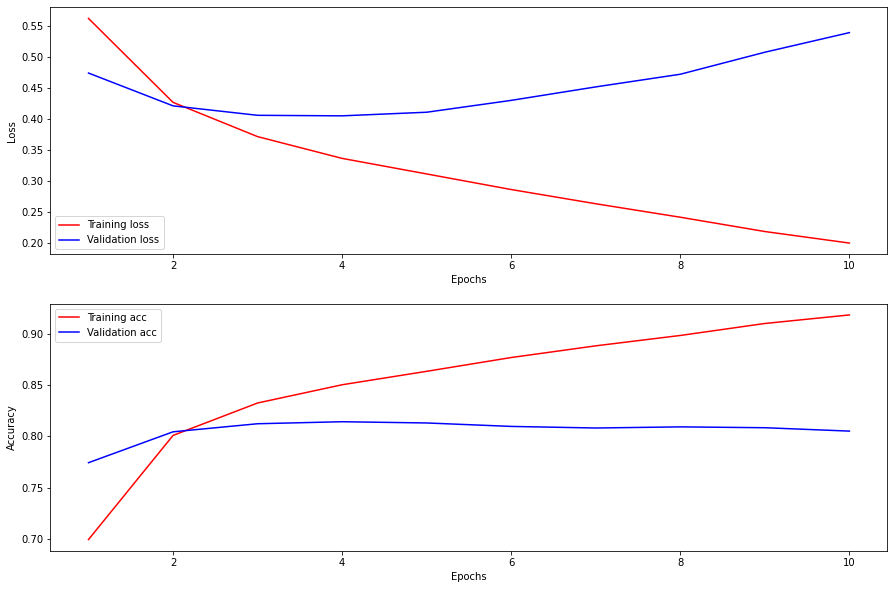

In [631]:
display_acc_loss(history.history)

#### 모델 평가

In [632]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1525/1525 - 3s - loss: 0.5404 - accuracy: 0.8044
[0.5404389500617981, 0.8044240474700928]


##### Global MaxPooling

In [633]:
model = gmp_layer(max_sentence_length, embedding_matrix)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
epochs=20
history=model.fit(X_train, 
                  y_train, 
                  epochs=epochs, 
                  batch_size=512, 
                  validation_data=(X_val, y_val), 
                  verbose=1)

Epoch 1/20
227/227 [==============================] - 5s 20ms/step - loss: 0.7167 - accuracy: 0.5169 - val_loss: 0.6595 - val_accuracy: 0.6225
Epoch 2/20
227/227 [==============================] - 5s 20ms/step - loss: 0.6346 - accuracy: 0.6614 - val_loss: 0.5499 - val_accuracy: 0.7224
Epoch 3/20
227/227 [==============================] - 4s 20ms/step - loss: 0.5253 - accuracy: 0.7408 - val_loss: 0.4950 - val_accuracy: 0.7611
Epoch 4/20
227/227 [==============================] - 4s 20ms/step - loss: 0.4717 - accuracy: 0.7773 - val_loss: 0.4652 - val_accuracy: 0.7796
Epoch 5/20
227/227 [==============================] - 4s 20ms/step - loss: 0.4362 - accuracy: 0.7992 - val_loss: 0.4499 - val_accuracy: 0.7885
Epoch 6/20
227/227 [==============================] - 4s 20ms/step - loss: 0.4105 - accuracy: 0.8138 - val_loss: 0.4336 - val_accuracy: 0.7997
Epoch 7/20
227/227 [==============================] - 5s 20ms/step - loss: 0.3906 - accuracy: 0.8261 - val_loss: 0.4262 - val_accuracy: 0.8054

#### Loss, Accuracy 그래프 시각화

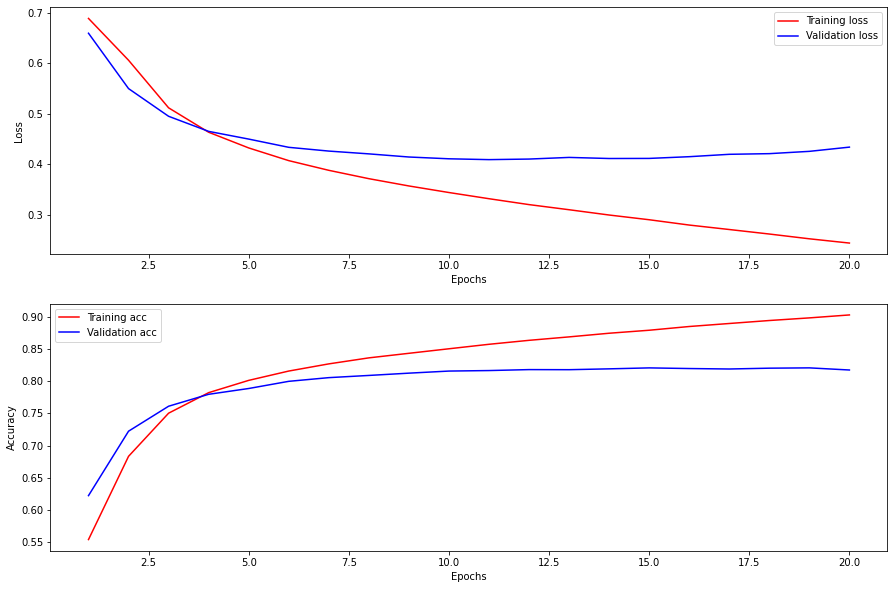

In [634]:
display_acc_loss(history.history)

#### 모델 평가

In [635]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1525/1525 - 2s - loss: 0.4356 - accuracy: 0.8154
[0.4356383681297302, 0.8153713941574097]


##### rnn

In [646]:
epochs=15
model = rnn_layer(max_sentence_length, embedding_matrix)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir="logs")
model.compile(optimizer=keras.optimizers.Adamax(lr=0.002), 
              loss=keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])
history=model.fit(X_train, 
                  y_train, 
                  epochs=epochs, 
                  batch_size=512, 
                  validation_data=(X_val, y_val), 
                  verbose=1, callbacks=[tensorboard_callback])

Epoch 1/15
227/227 [==============================] - 22s 72ms/step - loss: 0.6304 - accuracy: 0.6519 - val_loss: 0.4653 - val_accuracy: 0.7905
Epoch 2/15
227/227 [==============================] - 15s 65ms/step - loss: 0.4405 - accuracy: 0.8057 - val_loss: 0.4187 - val_accuracy: 0.8149
Epoch 3/15
227/227 [==============================] - 15s 65ms/step - loss: 0.3972 - accuracy: 0.8281 - val_loss: 0.3982 - val_accuracy: 0.8251
Epoch 4/15
227/227 [==============================] - 15s 65ms/step - loss: 0.3686 - accuracy: 0.8432 - val_loss: 0.3832 - val_accuracy: 0.8334
Epoch 5/15
227/227 [==============================] - 15s 65ms/step - loss: 0.3499 - accuracy: 0.8525 - val_loss: 0.3797 - val_accuracy: 0.8344
Epoch 6/15
227/227 [==============================] - 15s 65ms/step - loss: 0.3336 - accuracy: 0.8599 - val_loss: 0.3700 - val_accuracy: 0.8407
Epoch 7/15
227/227 [==============================] - 15s 65ms/step - loss: 0.3239 - accuracy: 0.8644 - val_loss: 0.3666 - val_accuracy:

#### Loss, Accuracy 그래프 시각화

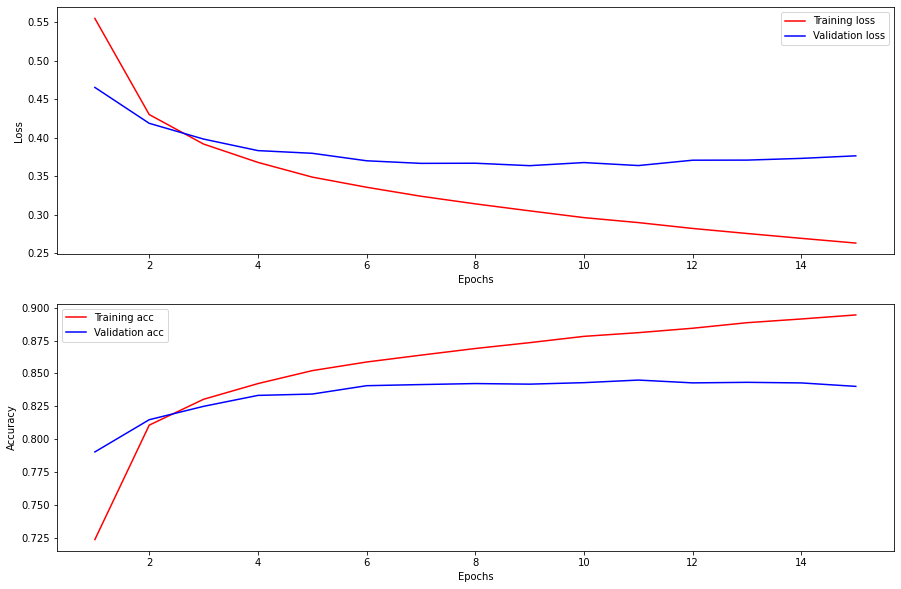

In [647]:
display_acc_loss(history.history)

#### 모델 평가

In [648]:
results = model.evaluate(X_test, y_test, verbose=2)
print(results)

1525/1525 - 23s - loss: 0.3791 - accuracy: 0.8402
[0.37912026047706604, 0.840156614780426]


# 회고

* 성능 0.01을 올리는게 이렇게 힘든 일이구나를 알게되었다.
* 감성분석이라는 것이 있구나를 알게되었다.
* 다양한 optimizer에 대해서 알게되었다.
* training loss와 validation loss의 관계를 좀 더 원활하게 사용했다.
* 관심이 가는 분야라 tensorflow나 다른 자료들을 더 찾아봐야겠다.
* 시간이 없어서 못했지만 실제 문장을 넣고 리뷰를 예측해보는 기능을 넣고 싶다.

# Reference

* https://wikidocs.net/44249
* https://www.tensorflow.org/tutorials/text/text_classification_rnn#%EB%91%90_%EA%B0%9C_%EC%9D%B4%EC%83%81%EC%9D%98_lstm_%EB%A0%88%EC%9D%B4%EC%96%B4_%EC%8C%93%EA%B8%B0
* https://hyemin-kim.github.io/2020/08/29/E-Python-TextMining-2/